In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from useful_func import *
import os

In [99]:
fs = 40
fs2 = 40/100

In [93]:
df = pd.read_csv('info_events.csv', index_col=0)
df['Picked arrival'] = pd.to_datetime(df['Picked arrival'])
df['file_start'] = pd.to_datetime(df['file_start'])
diff = (df['Picked arrival']- df['file_start'])
df['diff'] = diff.dt.total_seconds()
df['signal_to_end'] = np.array([len(np.fromfile(file, dtype = np.int32))/fs for file in df['file']]) - df['diff']
df = df.sort_values(by='Picked arrival')


In [3]:
all_files = []
for dossier_actuel, sous_dossiers, fichiers in os.walk('data\DonneesB23'):
    if "_MACOSX" not in dossier_actuel:
        for fichier in fichiers:
            if '.DS_Store' not in fichier:
                path = os.path.join(dossier_actuel, fichier)
                y = np.fromfile(path, dtype=np.int32)
                if len(y)/fs > 2*60*60 :
                    all_files.append(path)
del y
noisy_files = []
known_files = list(df['file'].unique())
for file in all_files :
    if file not in known_files :
        noisy_files.append(file)

In [8]:
def get_positives(files, events_time, demi_duree, n, fs=40, rd = True):

    signal_tronque = []
    signals = [ np.fromfile(file, dtype=np.int32) for file in files]

    i = 0
    while len(signal_tronque) < n :
        shift = np.random.normal(0, demi_duree/1000, 1)[0]
        if not rd :
            shift = 0
        a = int(events_time[i] + shift - demi_duree)
        b = int(events_time[i] + shift + demi_duree)

        if a > 0 and b < len(signals[i])/fs :
            y = signals[i][ a*fs : b*fs ]
            signal_tronque.append(y)

        i = (i + 1) % len(files)

    return signal_tronque
        


def get_negatives(noisy_files, duree, nb_0, fs=40):
    signals = [ np.fromfile(file, dtype=np.int32) for file in noisy_files]

    X_0 = []
    i = 0
    while len(X_0) < nb_0 :
        T = int(len(signals[i])/fs)
        t = np.random.randint(T - duree)
        y = signals[i][t*fs : t*fs + duree*fs]
        X_0.append(y)
            
        i = (i + 1) % len(noisy_files)
    return X_0



# premier modèle biaisé pour comprendre ce que regarde l'algorithme

In [9]:
demi_duree = 60*60 

n = 300
mask = (df['Tag']!='S1') & (df['Tag']!='*') 
files = df[ mask ]['file'].values
events_time = df[ mask ]['diff'].to_numpy(np.int32)


signal_tronque =  get_positives(files, events_time, demi_duree, n)

print(n, 'positives')

nb_0 = int(n*1.5)

X_0 = get_negatives(noisy_files, 2*demi_duree, nb_0)

print(nb_0, 'negatives')

y_0 = np.zeros(len(X_0))
y_1 = np.ones(len(signal_tronque))

X = np.concatenate((X_0, signal_tronque))
y = np.concatenate((y_0, y_1))


del X_0, y_0, y_1, signal_tronque


X = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(X, 100)))))
print(X.shape)

300 positives
450 negatives
(750, 2880)


Accuracy: 0.9866666666666667
tp: 27
tn: 47
fp: 1
fn: 0
precision: 0.96
recall: 1.0
f1 score: 0.98
kappa: 0.97


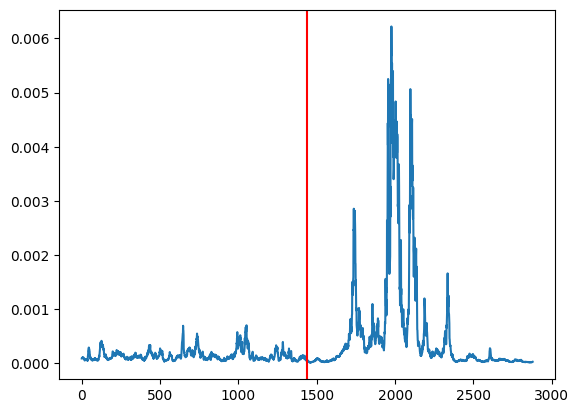

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
model = RandomForestClassifier(n_estimators=10000, max_depth=20, criterion='gini', class_weight='balanced_subsample', verbose=0, n_jobs=-1, max_features='sqrt')
model.fit(X_train, y_train)
predictions = model.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
tp = np.logical_and(predictions, y_test)
tn = np.logical_and(np.logical_not(predictions), np.logical_not(y_test))
fp = np.logical_and(predictions, np.logical_not(y_test))
fn = np.logical_and(np.logical_not(predictions), y_test)
print(f"tp: {np.sum(tp)}")
print(f"tn: {np.sum(tn)}")
print(f"fp: {np.sum(fp)}")
print(f"fn: {np.sum(fn)}")
precision = np.sum(tp)/(np.sum(tp)+np.sum(fp))
recall = np.sum(tp)/(np.sum(tp)+np.sum(fn))
f1 = 2*precision*recall/(precision+recall)
print(f"precision: {round(precision,2)}")
print(f"recall: {round(recall,2)}")
print(f"f1 score: {round(f1, 2)}")
p0 = (np.sum(tp)+np.sum(tn))/(np.sum(tp)+np.sum(tn)+np.sum(fp)+np.sum(fn))
pe = ((np.sum(tp)+np.sum(fp))*(np.sum(tp)+np.sum(fn))+(np.sum(fn)+np.sum(tn))*(np.sum(fp)+np.sum(tn)))/((np.sum(tp)+np.sum(tn)+np.sum(fp)+np.sum(fn))**2)
kappa = (p0-pe)/(1-pe)
print(f"kappa: {round(kappa, 2)}")

plt.plot(model.feature_importances_)
plt.axvline(demi_duree*fs/100, color='r')

In [12]:
def get_positives(files, events_time, demi_duree, n, fs=40, rd = True, d = 1000):

    signal_tronque = []
    signals = [ np.fromfile(file, dtype=np.int32) for file in files]

    i = 0
    while len(signal_tronque) < n :
        shift = np.random.normal(0, demi_duree/d, 1)[0]
        if not rd :
            shift = 0
        a = int(events_time[i] + shift)
        b = int(events_time[i] + shift + demi_duree)

        if a > 0 and b < len(signals[i])/fs :
            y = signals[i][ a*fs : b*fs ]
            signal_tronque.append(y)

        i = (i + 1) % len(files)

    return signal_tronque
        


def get_negatives(noisy_files, demi_duree, nb_0, fs=40):
    signals = [ np.fromfile(file, dtype=np.int32) for file in noisy_files]

    X_0 = []
    i = 0
    while len(X_0) < nb_0 :
        T = int(len(signals[i])/fs)
        t = np.random.randint(T - demi_duree)
        y = signals[i][t*fs : t*fs + demi_duree*fs]
        X_0.append(y)
            
        i = (i + 1) % len(noisy_files)
    return X_0



In [14]:
bins = np.arange(200, 1050, 200, dtype=np.int32)
bins = [ (bins[k], bins[k+1]) for k in range(len(bins)-1)]
print(bins)

demi_duree = 60*60 

mask = (df['Tag']!='S1') & (df['Tag']!='*') 

n = 400

mask_t = np.random.randint(0, 10, len(mask)) < 8
files = df[ mask & mask_t]['file'].values
events_time = df[ mask & mask_t]['diff'].to_numpy(np.int32)


signal_tronque =  get_positives(files, events_time, demi_duree, n, d=500)

print(n, 'positives')

nb_0 = int(n*2)

X_0 = get_negatives(noisy_files, demi_duree, nb_0)

print(nb_0, 'negatives')

y_0 = np.zeros(len(X_0))
y_1 = np.ones(len(signal_tronque))

X = np.concatenate((X_0, signal_tronque))
y = np.concatenate((y_0, y_1))


del X_0, y_0, y_1, signal_tronque


X = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(X, 100)))))


X_reduit = []
for x in X :
    x_r = []
    for a,b in bins:
        s = x[a:b]
        x_r += [np.mean(s)]
        #x_r += [np.mean(s)]
    X_reduit.append(x_r)
X_reduit = np.array(X_reduit)
print(X_reduit.shape)

X_train, X_test, y_train, y_test = train_test_split(X_reduit, y, test_size=0.1)
model = RandomForestClassifier(n_estimators=100, max_depth=20, criterion='gini', class_weight='balanced_subsample', verbose=0, n_jobs=-1, max_features='sqrt')
model.fit(X_train, y_train)

files = df[ mask & (1-mask_t)]['file'].values
events_time = df[ mask & (1-mask_t)]['diff'].to_numpy(np.int32)


signal_tronque =  get_positives(files, events_time, demi_duree, len(files))

test = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(signal_tronque, 100)))))
X_reduit_test = []
for x in test :
    x_r = []
    for a,b in bins:
        s = x[a:b]
        x_r += [np.mean(s)]
        #x_r += [np.mean(s)]
    X_reduit_test.append(x_r)
X_reduit_test = np.array(X_reduit_test)

res = model.predict(X_reduit_test)

print( 'score positif' , sum(res), '/', len(res), ':', sum(res)/len(res))

test_0 = get_negatives(noisy_files, demi_duree, 2*len(files))
test_0 = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(test_0, 100)))))
X_reduit_test_0 = []
for x in test_0 :
    x_r = []
    for a,b in bins:
        s = x[a:b]
        x_r += [np.mean(s)]
        #x_r += [np.mean(s)]
    X_reduit_test_0.append(x_r)
X_reduit_test_0 = np.array(X_reduit_test_0)

res_0 = model.predict(X_reduit_test_0)

print( 'score negatif', sum(1-res_0), '/', len(res_0), ':', sum(1-res_0)/len(res_0))

tp = res
tn =  (1-res_0)
fp = res_0
fn = (1-res)
print(f"tp: {np.sum(tp)}")
print(f"tn: {np.sum(tn)}")
print(f"fp: {np.sum(fp)}")
print(f"fn: {np.sum(fn)}")
acc = (np.sum(tp)+np.sum(tn))/(np.sum(tp)+np.sum(tn)+np.sum(fp)+np.sum(fn))
print(f"accuracy: {acc}")
precision = np.sum(tp)/(np.sum(tp)+np.sum(fp))
recall = np.sum(tp)/(np.sum(tp)+np.sum(fn))
f1 = 2*precision*recall/(precision+recall)
print(f"precision: {round(precision,2)}")
print(f"recall: {round(recall,2)}")
print(f"f1 score: {round(f1, 2)}")
p0 = (np.sum(tp)+np.sum(tn))/(np.sum(tp)+np.sum(tn)+np.sum(fp)+np.sum(fn))
pe = ((np.sum(tp)+np.sum(fp))*(np.sum(tp)+np.sum(fn))+(np.sum(fn)+np.sum(tn))*(np.sum(fp)+np.sum(tn)))/((np.sum(tp)+np.sum(tn)+np.sum(fp)+np.sum(fn))**2)
kappa = (p0-pe)/(1-pe)
print(f"kappa: {round(kappa, 2)}")

[(200, 400), (400, 600), (600, 800), (800, 1000)]
400 positives
800 negatives
(1200, 4)
score positif 17.0 / 24 : 0.7083333333333334
score negatif 47.0 / 48 : 0.9791666666666666
tp: 17.0
tn: 47.0
fp: 1.0
fn: 7.0
accuracy: 0.8888888888888888
precision: 0.94
recall: 0.71
f1 score: 0.81
kappa: 0.73


In [29]:
i=8

47
**
1 events detected


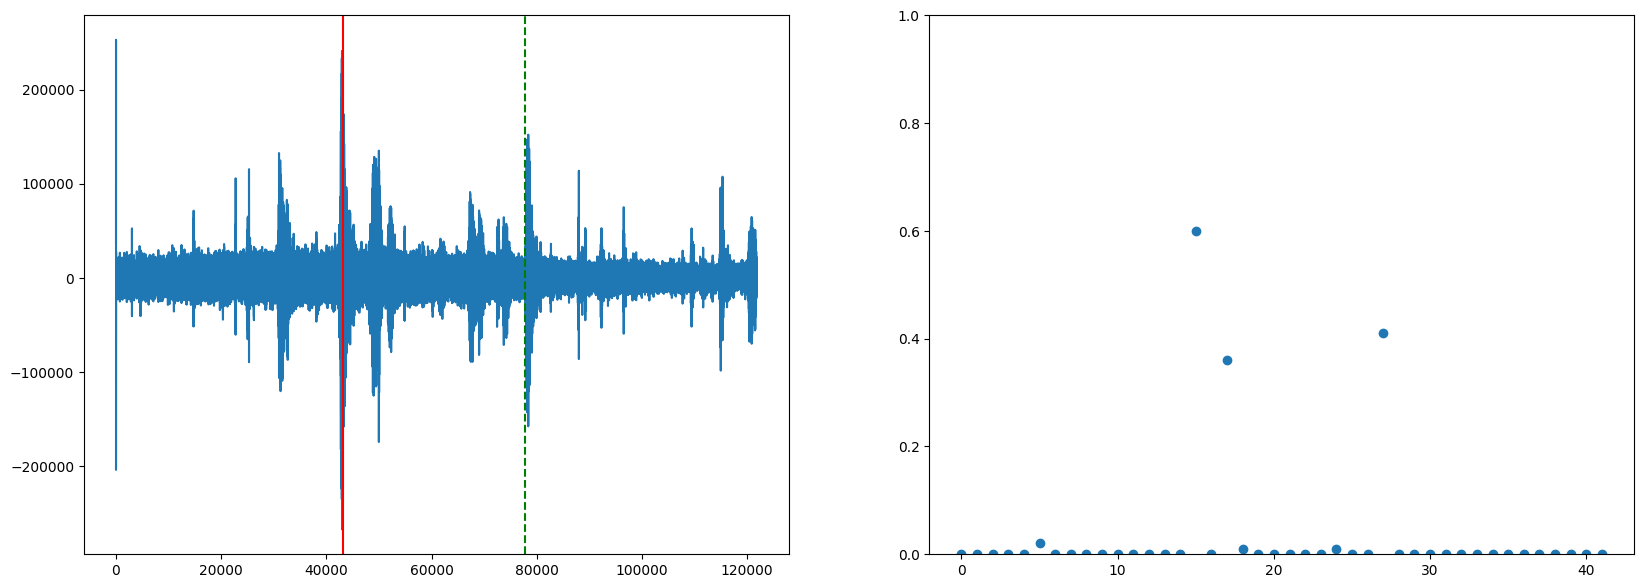

In [91]:
print(i)
file  = df['file'].iloc[i]
print(df['Tag'].iloc[i])
y = np.fromfile(file, dtype=np.int32)
T = len(y)/fs
intervalle = 2*60*60
nb_echant = int(T/intervalle)
X_t = []
for j in range(nb_echant) :
    if len(y[intervalle*j*fs : intervalle*j*fs + 1000*100]) == 1000*100 :
        X_t.append(y[intervalle*j*fs : intervalle*j*fs + 1000*100])


X_t = list(map(get_mov_rms, map(bp, signal.decimate(np.array(X_t), 100))))
X_reduit = []
for x in X_t :
    x_r = []
    for a,b in bins:
        s = x[a:b]
        x_r += [np.mean(s)]
        #x_r += [np.mean(s)]
    X_reduit.append(x_r)
X_reduit = np.array(X_reduit)

predictions = model.predict_proba(X_reduit)[:,1]
indices = np.where(predictions > .5)[0]
print(len(indices), 'events detected')
y_d = bp(signal.decimate(y, 100))
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(y_d)

for j in indices :
    plt.axvline(intervalle*j*fs/100, color='r')
plt.axvline(df['diff'].iloc[i]*fs/100, color='g', linestyle='--')

plt.subplot(1,2,2)
plt.plot(predictions, 'o')
plt.ylim(0,1)
i+=1

In [53]:
i-=1